In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import re
#from scipy.optimize import curve_fit
#import mdtraj as md
import os

In [2]:
'''
Extract trajectory from directory of lammps files, only equilibrium state (1/2 to end)
'''
def dir_to_trajs(directory):
    """
    loads atom positions from all LAMMPS files in given directory
    
    input directory: path of directory e.g. run3-100_dumplin (string)
    output: positions of all atoms at different times (numpy array) 
    """
    a = []
    # iterate over files in
    # that directory
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a file: 
        if os.path.isfile(f):
            a.append(np.loadtxt(f, skiprows=9, usecols=(1,2,3)))
    
    return np.asarray(a[-round(len(a)/2):])#[a[-125],a[-1]]

In [3]:
'''
Compute MSDs as function of genetic distance 
delta set the number of steps of the genomic distance binning
refatom set the atom wrt we compute the MSDs, if needed
cutoff set the max genetic distance analysed
''' 
def calcMSDs(directory,delta=1,samplesize=100,refatom=None,cutoff=np.inf):
    trajs = dir_to_trajs(directory)
    MSDs = []
    errs = []
    if refatom == None:
        for gendist in range(1,trajs.shape[1],delta):
            a = []
            try:
                refatoms = np.random.choice(range(trajs.shape[1]-gendist), size=samplesize, replace=False)
            except:
                refatoms = range(trajs.shape[1]-gendist)
            for atom1 in refatoms:
                temp = trajs[:,atom1]-trajs[:,atom1+gendist]
                a.append(np.linalg.norm(temp, axis=1)**2)
            allSDs = np.asarray(a)
            MSD, err = np.mean(allSDs), np.std(allSDs, ddof=1) / np.sqrt(np.size(allSDs))
            MSDs.append(MSD)
            errs.append(err)       
    else:
        for gendist in range(1,min(trajs.shape[1]-(refatom-1),cutoff),delta):
            temp = trajs[:,refatom-1]-trajs[:,refatom-1+gendist]
            allSDs = np.linalg.norm(temp, axis=1)**2
            MSD, err = np.mean(allSDs), np.std(allSDs, ddof=1) / np.sqrt(np.size(allSDs))
            MSDs.append(MSD)
            errs.append(err)
    
    return np.asarray(MSDs), np.asarray(errs)

In [4]:
def plotMSDs(directory,delta=1,samplesize=100,refatom=None,compareruns=False):
    #Enable lin fitting of first fit_range_limit points
    fitlin = True
    fit_range_limit = 40

    
    if compareruns == False:
        runs = directory.split('/')[-1]
        MSDs, errs = calcMSDs(directory,delta,samplesize,refatom)
        gendists = delta*np.arange(1, len(MSDs)+1)
        plt.errorbar(gendists, MSDs, yerr=errs, fmt=',', linestyle='None') # pixel marker and no line
        if fitlin == True:
            a, b = np.polyfit(gendists[:fit_range_limit],MSDs[:fit_range_limit], 1)
            print('fit params:',a, b)
            print('fit interval:',gendists[fit_range_limit])
            plt.plot(gendists,a*gendists+b)
    elif compareruns == True:
        runs = ''
        for count,directory in enumerate(directory):
            runs += directory.split('/')[-1]
            MSDs, errs = calcMSDs(directory,delta,samplesize,refatom)
            gendists = delta*np.arange(1, len(MSDs)+1)
            plt.errorbar(gendists, MSDs, yerr=errs, fmt=',', linestyle='None', label=directory.split('/')[-1]) # pixel marker and no line
        plt.legend(loc='upper left')
    
    if refatom == None:
        plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a function of genomic distance')
    else:
        plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a function of genomic distance'+'\n'+'atom No '+str(refatom)+' is the reference')
    plt.xlabel(r'Genomic distance [bp]')
    plt.ylabel(r'$\left\langle r^2 \right\rangle$')
    
    plt.grid()
    plt.tight_layout()
    #plt.savefig('../plots/'+'MSDvsgendist_'+runs+'_delta'+str(delta)+'_ssize'+str(samplesize)+'.pdf', format='pdf')
    plt.show()

fit params: 3.817087667296344 631.8151145731101
fit interval: 410


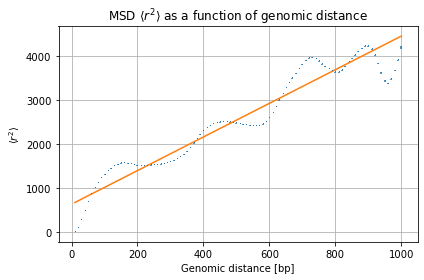

CPU times: user 6.76 s, sys: 74.8 ms, total: 6.83 s
Wall time: 7.13 s


In [5]:
%%time
directory = '../run2-1000/dumplin_A20'
delta = 10 # difference in gendist between adjacent data points in the plot
samplesize = 1000 # No of randomly chosen pairs of atoms from which MSD is calculated for each gendist
plotMSDs(directory,delta,samplesize,compareruns=False)


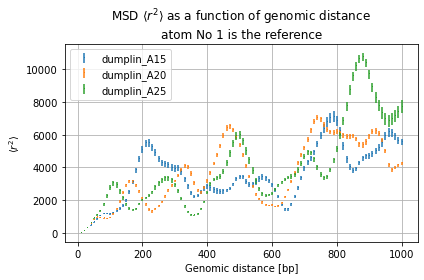

CPU times: user 13 s, sys: 251 ms, total: 13.3 s
Wall time: 13.7 s


In [6]:
%%time
directory = ['../run2-1000/dumplin_A15', '../run2-1000/dumplin_A20', '../run2-1000/dumplin_A25']
delta = 10 # difference in gendist between adjacent data points in the plot
#samplesize = 100 # No of randomly chosen pairs of atoms from which MSD is calculated for each gendist
ref = 1
plotMSDs(directory,delta,refatom=ref,compareruns=True)

## Multiple runs

In [7]:
def MSDs_avgruns(directory,delta=1,samplesize=100,refatom=None,cutoff=np.inf):
    allMSDs = []
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        # checking if it is a directory:
        if os.path.isdir(f):
            for file in os.listdir(f):
                dumplin = os.path.join(f, file)
                if os.path.isdir(dumplin):
                    allMSDs.append(calcMSDs(dumplin,delta,samplesize,refatom,cutoff)[0])
            
    avgMSDs = np.mean(np.asarray(allMSDs), axis=0)
    errs = np.std(np.asarray(allMSDs), axis=0) / np.sqrt(len(allMSDs))
    gendists = delta*np.arange(1, len(avgMSDs)+1)
    
    return avgMSDs, errs, gendists

In [11]:
def plotMSDs_avgruns(directory,delta=1,samplesize=100,refatom=None,cutoff=np.inf):
    avgMSDs, errs, gendists = MSDs_avgruns(directory,delta,samplesize,refatom,cutoff)
    n_runs = 0
    for filename in os.listdir(directory):
        n_runs+=1

    if refatom==None:
        plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a fct of gendist averaged over '+str(n_runs)+' runs')
    else:
        plt.title(r'MSD $\left\langle r^2 \right\rangle$ as a fct of gendist averaged over '+str(n_runs)+' runs\n'+'atom No '+str(refatom)+' is the reference')
    plt.xlabel(r'Genomic distance [bp]')
    plt.ylabel(r'$\left\langle r^2 \right\rangle$')
    plt.errorbar(gendists, avgMSDs, yerr=errs, fmt='.', linestyle='None') # , pixel marker or . point marker and no line
    plt.grid()
    plt.tight_layout()
    plt.savefig('../plots/'+'avgMSDvsgendist_'+directory.split('/')[-1]+'_delta'+str(delta)+'_ssize'+str(samplesize)+'.pdf', format='pdf')
    plt.show()

### Anchoring and 1 wall, A = 0
CARE, BROKEN DUE TO ENUMERATION STARTING FROM CENTROMERE

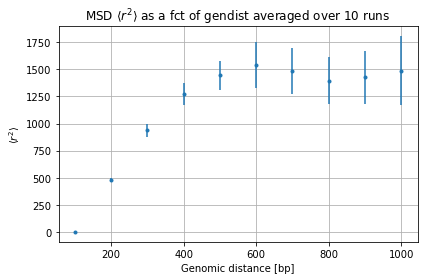

CPU times: user 18.6 s, sys: 118 ms, total: 18.7 s
Wall time: 18.7 s


In [12]:
%%time
# directory structure needed: cluster/simulation/dumplin/dumpling_files.lammpstrj
directory = '../run2-1000/dumplin_cluster_anchoring_1wall_A0'
delta = 100 # difference in gendist between adjacent data points in the plot
#samplesize = 100 # No of randomly chosen pairs of atoms from which MSD is calculated for each gendist
plotMSDs_avgruns(directory,delta)

In the following example, one atom (the reference atom) is fixed throughout the whole calculation.

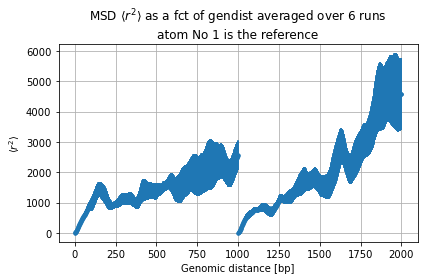

CPU times: user 25.6 s, sys: 265 ms, total: 25.9 s
Wall time: 28 s


In [13]:
%%time
directory = '../run6-2000/dumplin_cluster_anchoring_1wall_A7'
delta = 1
ref = 1
plotMSDs_avgruns(directory,delta,refatom=ref)

## Subpolymer

We now want to fix a subpolymer of given length and examine whether its behavior differs depending on the total chain length.

In [ ]:
%%time
directory = '../simdata/runs100-1-21'
delta = 1
ref = 1
subpolymer_len = 100
avgMSDs, errs, gendists = MSDs_avgruns(directory,delta,refatom=ref,cutoff=subpolymer_len)

L = np.linspace(0,np.max(gendists))
lp = 20
wlc = 2*lp*L-2*lp**2*(1-np.exp(-L/lp))

plt.xlabel(r'Genomic distance [bp]')
plt.ylabel(r'$\left\langle r^2 \right\rangle$')
plt.errorbar(gendists, avgMSDs, yerr=errs, fmt='.', linestyle='None', label='simulation data') # , pixel marker or . point marker and no line
plt.plot(L,wlc,label='WLC model')
plt.legend(loc='upper left')
plt.title(r'Multiple runs with 100 atoms and WLC model')
plt.grid()
plt.tight_layout()
plt.savefig('../plots/'+directory.split('/')[-1]+'_vs_WLC_subpolymerlen'+str(subpolymer_len)+'.pdf', format='pdf')
plt.show()

In [ ]:
%%time
directory = '../simdata/runs1000-1-20'
delta = 1
ref = 1
subpolymer_len = 100
avgMSDs, errs, gendists = MSDs_avgruns(directory,delta,refatom=ref,cutoff=subpolymer_len)

L = np.linspace(0,np.max(gendists))
lp = 20
wlc = 2*lp*L-2*lp**2*(1-np.exp(-L/lp))

plt.xlabel(r'Genomic distance [bp]')
plt.ylabel(r'$\left\langle r^2 \right\rangle$')
plt.errorbar(gendists, avgMSDs, yerr=errs, fmt='.', linestyle='None', label='simulation data') # , pixel marker or . point marker and no line
plt.plot(L,wlc,label='WLC model')
plt.legend(loc='upper left')
plt.title(r'Subpolymer of multiple runs with 1000 atoms and WLC model')
plt.grid()
plt.tight_layout()
plt.savefig('../plots/'+directory.split('/')[-1]+'_vs_WLC_subpolymerlen'+str(subpolymer_len)+'.pdf', format='pdf')
plt.show()

In [41]:
def plotsubpolymers(directories,delta=1,refatoms=None,length=100):
    if refatoms == None:
        refatoms = np.ones(len(directories), dtype=np.int64)
    polymers = ''
    for count,directory in enumerate(directories):
        polymers += directory.split('/')[-1]
        allMSDs = []
        for filename in os.listdir(directory):
            # checking if it is a directory:
            f = os.path.join(directory, filename)
            if os.path.isdir(f):
                for file in os.listdir(f):
                    dumplin = os.path.join(f, file)
                    if os.path.isdir(dumplin):
                        allMSDs.append(calcMSDs(dumplin,delta,refatom=refatoms[count],cutoff=length)[0])
            
        avgMSDs = np.mean(np.asarray(allMSDs), axis=0)
        errs = np.std(np.asarray(allMSDs), axis=0) / np.sqrt(len(allMSDs))
        gendists = delta*np.arange(1, len(avgMSDs)+1)
    
        plt.errorbar(gendists, avgMSDs, yerr=errs, fmt='.', linestyle='None', label=directory.split('/')[-1]) # , pixel marker or . point marker and no line
    
    plt.title(r'Subpolymers of length '+str(length)+' for different total chain lengths\n'+'atom No '+str(refatoms)+' is the reference')
    plt.xlabel(r'Genomic distance [bp]')
    plt.ylabel(r'$\left\langle r^2 \right\rangle$')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.savefig('../plots/'+'subpolymers'+'_length'+str(length)+'_'+polymers+'_delta'+str(delta)+'_ref'+str(refatoms)+'.pdf', format='pdf')
    plt.show()

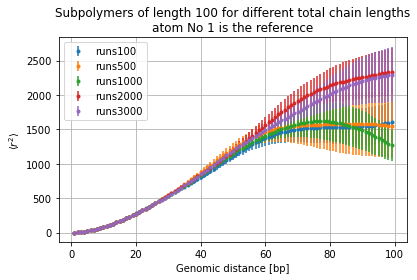

Wall time: 2min 29s


In [9]:
%%time
directories = ['../simdata/runs100','../simdata/runs500','../simdata/runs1000','../simdata/runs2000','../simdata/runs3000']
delta = 1
ref = 1
subpolymer_len = 100
plotsubpolymers(directories,delta,ref,subpolymer_len)

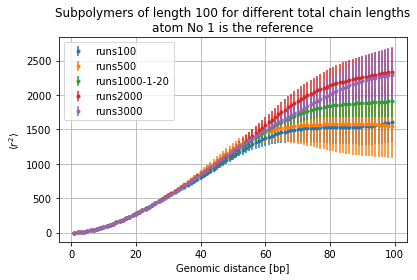

Wall time: 2min 12s


In [30]:
%%time
directories = ['../simdata/runs100','../simdata/runs500','../simdata/runs1000-1-20','../simdata/runs2000','../simdata/runs3000']
delta = 1
ref = 1
subpolymer_len = 100
plotsubpolymers(directories,delta,ref,subpolymer_len)

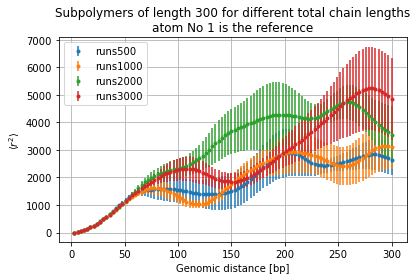

Wall time: 1min 36s


In [10]:
%%time
directories = ['../simdata/runs100','../simdata/runs500','../simdata/runs1000','../simdata/runs2000','../simdata/runs3000']
delta = 3
ref = 1
subpolymer_len = 300
plotsubpolymers(directories,delta,ref,subpolymer_len)

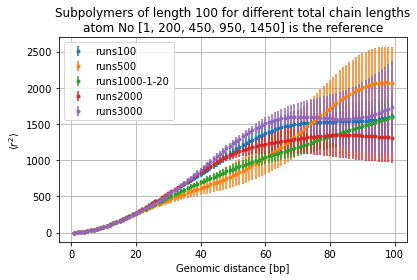

Wall time: 2min 19s


In [42]:
%%time
directories = ['../simdata/runs100','../simdata/runs500','../simdata/runs1000-1-20','../simdata/runs2000','../simdata/runs3000']
delta = 1
ref = [1,200,450,950,1450]
subpolymer_len = 100
plotsubpolymers(directories,delta,ref,subpolymer_len)

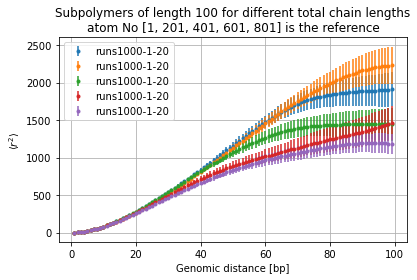

Wall time: 4min 9s


In [43]:
%%time
directories = ['../simdata/runs1000-1-20','../simdata/runs1000-1-20','../simdata/runs1000-1-20','../simdata/runs1000-1-20','../simdata/runs1000-1-20',]
delta = 1
ref = [1,201,401,601,801]
subpolymer_len = 100
plotsubpolymers(directories,delta,ref,subpolymer_len)